# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for KNN Model
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [3]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\classification_helper.py'>


In [4]:
!python -V

Python 3.10.6


# 1. Loading the data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [7]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [8]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [9]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [10]:
# relevance table has the information about which feature is relevant for the classification task based on p-value

relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
torque__friedrich_coefficients__coeff_3__m_3__r_30,torque__friedrich_coefficients__coeff_3__m_3__...,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__max_langevin_fixed_point__m_3__r_30,torque__max_langevin_fixed_point__m_3__r_30,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__number_crossing_m__m_-1,torque__number_crossing_m__m_-1,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False


In [11]:
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [14]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [15]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [16]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [17]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1550, 615), (1550, 8), (750, 615), (750, 8))

# 2. Hyperparameter optimization for KNN Model

In [19]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.neighbors import KNeighborsClassifier

In [25]:
parameters = {'classifier__n_neighbors':[1,3,5,8,12,16,24,36], 'classifier__weights':['uniform', 'distance'],
              'classifier__algorithm':['ball_tree', 'kd_tree', 'brute'], 'classifier__p':[1,2,3,4,5]}

search = GridSearchCV(BinaryRelevance(KNeighborsClassifier()), parameters, cv=5, scoring='accuracy', verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5; 1/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform
[CV 1/5; 1/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform;, score=0.671 total time=   3.3s
[CV 2/5; 1/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform
[CV 2/5; 1/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform;, score=0.668 total time=   3.0s
[CV 3/5; 1/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform
[CV 3/5; 1/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform;, score=0.677 total time=   2.5s
[CV 4/5; 1/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=1,

[CV 4/5; 6/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=3, classifier__weights=distance;, score=0.503 total time=  31.6s
[CV 5/5; 6/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=3, classifier__weights=distance
[CV 5/5; 6/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=3, classifier__weights=distance;, score=0.523 total time=  30.1s
[CV 1/5; 7/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=uniform
[CV 1/5; 7/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=uniform;, score=0.432 total time=  26.7s
[CV 2/5; 7/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=uniform
[CV 2/5; 7/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=uniform;, score=0.442 tot

[CV 3/5; 12/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance;, score=0.687 total time=   3.3s
[CV 4/5; 12/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance
[CV 4/5; 12/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance;, score=0.668 total time=   3.3s
[CV 5/5; 12/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance
[CV 5/5; 12/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=1, classifier__weights=distance;, score=0.694 total time=   3.2s
[CV 1/5; 13/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=uniform
[CV 1/5; 13/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=uniform;, score=

[CV 2/5; 18/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=4, classifier__weights=distance;, score=0.397 total time=  29.7s
[CV 3/5; 18/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=4, classifier__weights=distance
[CV 3/5; 18/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=4, classifier__weights=distance;, score=0.429 total time=  27.9s
[CV 4/5; 18/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=4, classifier__weights=distance
[CV 4/5; 18/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=4, classifier__weights=distance;, score=0.452 total time=  29.4s
[CV 5/5; 18/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=4, classifier__weights=distance
[CV 5/5; 18/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=3, classifier__p=4, classifier__weights=distance;, scor

[CV 1/5; 24/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=2, classifier__weights=distance;, score=0.523 total time=   2.2s
[CV 2/5; 24/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=2, classifier__weights=distance
[CV 2/5; 24/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=2, classifier__weights=distance;, score=0.529 total time=   2.1s
[CV 3/5; 24/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=2, classifier__weights=distance
[CV 3/5; 24/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=2, classifier__weights=distance;, score=0.539 total time=   2.1s
[CV 4/5; 24/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=2, classifier__weights=distance
[CV 4/5; 24/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=2, classifier__weights=distance;, scor

[CV 5/5; 29/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=5, classifier__weights=uniform;, score=0.290 total time=  26.2s
[CV 1/5; 30/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=5, classifier__weights=distance
[CV 1/5; 30/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=5, classifier__weights=distance;, score=0.339 total time=  26.4s
[CV 2/5; 30/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=5, classifier__weights=distance
[CV 2/5; 30/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=5, classifier__weights=distance;, score=0.287 total time=  27.7s
[CV 3/5; 30/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=5, classifier__weights=distance
[CV 3/5; 30/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=5, classifier__p=5, classifier__weights=distance;, score

[CV 4/5; 35/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=uniform;, score=0.377 total time=  34.5s
[CV 5/5; 35/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=uniform
[CV 5/5; 35/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=uniform;, score=0.361 total time=  33.0s
[CV 1/5; 36/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=distance
[CV 1/5; 36/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=distance;, score=0.426 total time=  33.4s
[CV 2/5; 36/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=distance
[CV 2/5; 36/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=distance;, score=0

[CV 3/5; 41/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=uniform;, score=0.568 total time=   3.7s
[CV 4/5; 41/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=uniform
[CV 4/5; 41/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=uniform;, score=0.597 total time=   3.6s
[CV 5/5; 41/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=uniform
[CV 5/5; 41/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=uniform;, score=0.603 total time=   3.5s
[CV 1/5; 42/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=distance
[CV 1/5; 42/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=distance;, sc

[CV 2/5; 47/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=uniform;, score=0.274 total time=  30.6s
[CV 3/5; 47/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=uniform
[CV 3/5; 47/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=uniform;, score=0.245 total time=  29.5s
[CV 4/5; 47/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=uniform
[CV 4/5; 47/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=uniform;, score=0.287 total time=  30.6s
[CV 5/5; 47/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=uniform
[CV 5/5; 47/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=uniform;, scor

[CV 1/5; 53/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=uniform;, score=0.397 total time=   2.3s
[CV 2/5; 53/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=uniform
[CV 2/5; 53/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=uniform;, score=0.352 total time=   2.1s
[CV 3/5; 53/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=uniform
[CV 3/5; 53/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=uniform;, score=0.419 total time=   2.2s
[CV 4/5; 53/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=uniform
[CV 4/5; 53/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=uniform;, scor

[CV 5/5; 58/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=4, classifier__weights=distance;, score=0.274 total time=  29.3s
[CV 1/5; 59/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=uniform
[CV 1/5; 59/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=uniform;, score=0.197 total time=  27.7s
[CV 2/5; 59/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=uniform
[CV 2/5; 59/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=uniform;, score=0.223 total time=  28.7s
[CV 3/5; 59/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=uniform
[CV 3/5; 59/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=uniform;, sco

[CV 4/5; 64/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=2, classifier__weights=distance;, score=0.400 total time=   2.2s
[CV 5/5; 64/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=2, classifier__weights=distance
[CV 5/5; 64/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=2, classifier__weights=distance;, score=0.403 total time=   2.2s
[CV 1/5; 65/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=uniform
[CV 1/5; 65/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=uniform;, score=0.245 total time=  34.8s
[CV 2/5; 65/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=uniform
[CV 2/5; 65/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=uniform;, s

[CV 3/5; 70/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=5, classifier__weights=distance;, score=0.197 total time=  27.2s
[CV 4/5; 70/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=5, classifier__weights=distance
[CV 4/5; 70/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=5, classifier__weights=distance;, score=0.219 total time=  28.7s
[CV 5/5; 70/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=5, classifier__weights=distance
[CV 5/5; 70/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=24, classifier__p=5, classifier__weights=distance;, score=0.197 total time=  27.3s
[CV 1/5; 71/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=uniform
[CV 1/5; 71/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=uniform;,

[CV 2/5; 76/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=3, classifier__weights=distance;, score=0.252 total time=  35.9s
[CV 3/5; 76/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=3, classifier__weights=distance
[CV 3/5; 76/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=3, classifier__weights=distance;, score=0.239 total time=  35.1s
[CV 4/5; 76/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=3, classifier__weights=distance
[CV 4/5; 76/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=3, classifier__weights=distance;, score=0.265 total time=  36.5s
[CV 5/5; 76/240] START classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=3, classifier__weights=distance
[CV 5/5; 76/240] END classifier__algorithm=ball_tree, classifier__n_neighbors=36, classifier__p=3, classifier__weights=distance

[CV 1/5; 82/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=distance;, score=0.671 total time=   3.8s
[CV 2/5; 82/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=distance
[CV 2/5; 82/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=distance;, score=0.668 total time=   3.9s
[CV 3/5; 82/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=distance
[CV 3/5; 82/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=distance;, score=0.677 total time=   3.7s
[CV 4/5; 82/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=distance
[CV 4/5; 82/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=1, classifier__weights=distance;, score=0.697 total 

[CV 5/5; 87/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=uniform;, score=0.471 total time=  18.0s
[CV 1/5; 88/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=distance
[CV 1/5; 88/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=distance;, score=0.432 total time=  19.0s
[CV 2/5; 88/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=distance
[CV 2/5; 88/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=distance;, score=0.442 total time=  18.5s
[CV 3/5; 88/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=distance
[CV 3/5; 88/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=1, classifier__p=4, classifier__weights=distance;, score=0.458 total t

[CV 4/5; 93/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=uniform;, score=0.568 total time=   2.8s
[CV 5/5; 93/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=uniform
[CV 5/5; 93/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=uniform;, score=0.545 total time=   3.0s
[CV 1/5; 94/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=distance
[CV 1/5; 94/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=distance;, score=0.532 total time=   3.0s
[CV 2/5; 94/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=distance
[CV 2/5; 94/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=2, classifier__weights=distance;, score=0.539 total tim

[CV 3/5; 99/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=5, classifier__weights=uniform;, score=0.358 total time=  18.9s
[CV 4/5; 99/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=5, classifier__weights=uniform
[CV 4/5; 99/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=5, classifier__weights=uniform;, score=0.384 total time=  19.4s
[CV 5/5; 99/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=5, classifier__weights=uniform
[CV 5/5; 99/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=5, classifier__weights=uniform;, score=0.335 total time=  18.8s
[CV 1/5; 100/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=5, classifier__weights=distance
[CV 1/5; 100/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=3, classifier__p=5, classifier__weights=distance;, score=0.365 total tim

[CV 2/5; 105/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__p=3, classifier__weights=uniform;, score=0.410 total time=  24.2s
[CV 3/5; 105/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__p=3, classifier__weights=uniform
[CV 3/5; 105/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__p=3, classifier__weights=uniform;, score=0.432 total time=  23.8s
[CV 4/5; 105/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__p=3, classifier__weights=uniform
[CV 4/5; 105/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__p=3, classifier__weights=uniform;, score=0.490 total time=  24.5s
[CV 5/5; 105/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__p=3, classifier__weights=uniform
[CV 5/5; 105/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=5, classifier__p=3, classifier__weights=uniform;, score=0.435 total 

[CV 1/5; 111/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=1, classifier__weights=uniform;, score=0.513 total time=   4.7s
[CV 2/5; 111/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=1, classifier__weights=uniform
[CV 2/5; 111/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=1, classifier__weights=uniform;, score=0.590 total time=   4.7s
[CV 3/5; 111/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=1, classifier__weights=uniform
[CV 3/5; 111/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=1, classifier__weights=uniform;, score=0.581 total time=   4.5s
[CV 4/5; 111/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=1, classifier__weights=uniform
[CV 4/5; 111/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=1, classifier__weights=uniform;, score=0.619 total 

[CV 5/5; 116/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=3, classifier__weights=distance;, score=0.429 total time=  24.2s
[CV 1/5; 117/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=4, classifier__weights=uniform
[CV 1/5; 117/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=4, classifier__weights=uniform;, score=0.294 total time=  22.1s
[CV 2/5; 117/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=4, classifier__weights=uniform
[CV 2/5; 117/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=4, classifier__weights=uniform;, score=0.290 total time=  22.0s
[CV 3/5; 117/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=4, classifier__weights=uniform
[CV 3/5; 117/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=8, classifier__p=4, classifier__weights=uniform;, score=0.274 total

[CV 4/5; 122/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=distance;, score=0.645 total time=   4.7s
[CV 5/5; 122/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=distance
[CV 5/5; 122/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=1, classifier__weights=distance;, score=0.645 total time=   4.8s
[CV 1/5; 123/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=2, classifier__weights=uniform
[CV 1/5; 123/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=2, classifier__weights=uniform;, score=0.387 total time=   3.3s
[CV 2/5; 123/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=2, classifier__weights=uniform
[CV 2/5; 123/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=2, classifier__weights=uniform;, score=0.

[CV 3/5; 128/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=distance;, score=0.310 total time=  21.6s
[CV 4/5; 128/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=distance
[CV 4/5; 128/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=distance;, score=0.339 total time=  22.9s
[CV 5/5; 128/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=distance
[CV 5/5; 128/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=4, classifier__weights=distance;, score=0.294 total time=  21.5s
[CV 1/5; 129/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=5, classifier__weights=uniform
[CV 1/5; 129/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=12, classifier__p=5, classifier__weights=uniform;, score=

[CV 2/5; 134/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=distance;, score=0.442 total time=   3.3s
[CV 3/5; 134/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=distance
[CV 3/5; 134/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=distance;, score=0.477 total time=   3.2s
[CV 4/5; 134/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=distance
[CV 4/5; 134/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=distance;, score=0.487 total time=   3.2s
[CV 5/5; 134/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=distance
[CV 5/5; 134/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=2, classifier__weights=distance;, scor

[CV 1/5; 140/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=distance;, score=0.252 total time=  21.0s
[CV 2/5; 140/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=distance
[CV 2/5; 140/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=distance;, score=0.252 total time=  20.9s
[CV 3/5; 140/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=distance
[CV 3/5; 140/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=distance;, score=0.223 total time=  20.1s
[CV 4/5; 140/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=distance
[CV 4/5; 140/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=16, classifier__p=5, classifier__weights=distance;, scor

[CV 5/5; 145/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=uniform;, score=0.252 total time=  24.8s
[CV 1/5; 146/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=distance
[CV 1/5; 146/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=distance;, score=0.294 total time=  25.8s
[CV 2/5; 146/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=distance
[CV 2/5; 146/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=distance;, score=0.284 total time=  26.6s
[CV 3/5; 146/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=distance
[CV 3/5; 146/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=24, classifier__p=3, classifier__weights=distance;, score

[CV 4/5; 151/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=uniform;, score=0.500 total time=   5.1s
[CV 5/5; 151/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=uniform
[CV 5/5; 151/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=uniform;, score=0.523 total time=   5.0s
[CV 1/5; 152/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=distance
[CV 1/5; 152/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=distance;, score=0.500 total time=   5.0s
[CV 2/5; 152/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=distance
[CV 2/5; 152/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=1, classifier__weights=distance;, score=0

[CV 3/5; 157/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=4, classifier__weights=uniform;, score=0.165 total time=  22.6s
[CV 4/5; 157/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=4, classifier__weights=uniform
[CV 4/5; 157/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=4, classifier__weights=uniform;, score=0.177 total time=  23.7s
[CV 5/5; 157/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=4, classifier__weights=uniform
[CV 5/5; 157/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=4, classifier__weights=uniform;, score=0.155 total time=  22.1s
[CV 1/5; 158/240] START classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=4, classifier__weights=distance
[CV 1/5; 158/240] END classifier__algorithm=kd_tree, classifier__n_neighbors=36, classifier__p=4, classifier__weights=distance;, score=0.1

[CV 2/5; 163/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=2, classifier__weights=uniform;, score=0.552 total time=   0.4s
[CV 3/5; 163/240] START classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=2, classifier__weights=uniform
[CV 3/5; 163/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=2, classifier__weights=uniform;, score=0.574 total time=   0.4s
[CV 4/5; 163/240] START classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=2, classifier__weights=uniform
[CV 4/5; 163/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=2, classifier__weights=uniform;, score=0.587 total time=   0.4s
[CV 5/5; 163/240] START classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=2, classifier__weights=uniform
[CV 5/5; 163/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=2, classifier__weights=uniform;, score=0.587 total time=   0.4s
[

[CV 2/5; 169/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=5, classifier__weights=uniform;, score=0.384 total time=  19.6s
[CV 3/5; 169/240] START classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=5, classifier__weights=uniform
[CV 3/5; 169/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=5, classifier__weights=uniform;, score=0.377 total time=  20.1s
[CV 4/5; 169/240] START classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=5, classifier__weights=uniform
[CV 4/5; 169/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=5, classifier__weights=uniform;, score=0.435 total time=  20.3s
[CV 5/5; 169/240] START classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=5, classifier__weights=uniform
[CV 5/5; 169/240] END classifier__algorithm=brute, classifier__n_neighbors=1, classifier__p=5, classifier__weights=uniform;, score=0.394 total time=  19.7s
[

[CV 2/5; 175/240] END classifier__algorithm=brute, classifier__n_neighbors=3, classifier__p=3, classifier__weights=uniform;, score=0.471 total time=  20.2s
[CV 3/5; 175/240] START classifier__algorithm=brute, classifier__n_neighbors=3, classifier__p=3, classifier__weights=uniform
[CV 3/5; 175/240] END classifier__algorithm=brute, classifier__n_neighbors=3, classifier__p=3, classifier__weights=uniform;, score=0.487 total time=  20.0s
[CV 4/5; 175/240] START classifier__algorithm=brute, classifier__n_neighbors=3, classifier__p=3, classifier__weights=uniform
[CV 4/5; 175/240] END classifier__algorithm=brute, classifier__n_neighbors=3, classifier__p=3, classifier__weights=uniform;, score=0.519 total time=  20.2s
[CV 5/5; 175/240] START classifier__algorithm=brute, classifier__n_neighbors=3, classifier__p=3, classifier__weights=uniform
[CV 5/5; 175/240] END classifier__algorithm=brute, classifier__n_neighbors=3, classifier__p=3, classifier__weights=uniform;, score=0.487 total time=  20.2s
[

[CV 2/5; 181/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=1, classifier__weights=uniform;, score=0.655 total time=   0.8s
[CV 3/5; 181/240] START classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=1, classifier__weights=uniform
[CV 3/5; 181/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=1, classifier__weights=uniform;, score=0.635 total time=   1.0s
[CV 4/5; 181/240] START classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=1, classifier__weights=uniform
[CV 4/5; 181/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=1, classifier__weights=uniform;, score=0.658 total time=   0.8s
[CV 5/5; 181/240] START classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=1, classifier__weights=uniform
[CV 5/5; 181/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=1, classifier__weights=uniform;, score=0.652 total time=   0.8s
[

[CV 2/5; 187/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=4, classifier__weights=uniform;, score=0.358 total time=  20.1s
[CV 3/5; 187/240] START classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=4, classifier__weights=uniform
[CV 3/5; 187/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=4, classifier__weights=uniform;, score=0.387 total time=  19.8s
[CV 4/5; 187/240] START classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=4, classifier__weights=uniform
[CV 4/5; 187/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=4, classifier__weights=uniform;, score=0.381 total time=  19.9s
[CV 5/5; 187/240] START classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=4, classifier__weights=uniform
[CV 5/5; 187/240] END classifier__algorithm=brute, classifier__n_neighbors=5, classifier__p=4, classifier__weights=uniform;, score=0.345 total time=  20.0s
[

[CV 2/5; 193/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=2, classifier__weights=uniform;, score=0.426 total time=   0.5s
[CV 3/5; 193/240] START classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=2, classifier__weights=uniform
[CV 3/5; 193/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=2, classifier__weights=uniform;, score=0.468 total time=   0.4s
[CV 4/5; 193/240] START classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=2, classifier__weights=uniform
[CV 4/5; 193/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=2, classifier__weights=uniform;, score=0.461 total time=   0.4s
[CV 5/5; 193/240] START classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=2, classifier__weights=uniform
[CV 5/5; 193/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=2, classifier__weights=uniform;, score=0.452 total time=   0.4s
[

[CV 2/5; 199/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=5, classifier__weights=uniform;, score=0.261 total time=  20.1s
[CV 3/5; 199/240] START classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=5, classifier__weights=uniform
[CV 3/5; 199/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=5, classifier__weights=uniform;, score=0.223 total time=  20.0s
[CV 4/5; 199/240] START classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=5, classifier__weights=uniform
[CV 4/5; 199/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=5, classifier__weights=uniform;, score=0.277 total time=  20.3s
[CV 5/5; 199/240] START classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=5, classifier__weights=uniform
[CV 5/5; 199/240] END classifier__algorithm=brute, classifier__n_neighbors=8, classifier__p=5, classifier__weights=uniform;, score=0.229 total time=  20.3s
[

[CV 1/5; 205/240] END classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=3, classifier__weights=uniform;, score=0.319 total time=  20.4s
[CV 2/5; 205/240] START classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=3, classifier__weights=uniform
[CV 2/5; 205/240] END classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=3, classifier__weights=uniform;, score=0.297 total time=  19.7s
[CV 3/5; 205/240] START classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=3, classifier__weights=uniform
[CV 3/5; 205/240] END classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=3, classifier__weights=uniform;, score=0.332 total time=  19.8s
[CV 4/5; 205/240] START classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=3, classifier__weights=uniform
[CV 4/5; 205/240] END classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=3, classifier__weights=uniform;, score=0.332 total time=  

[CV 5/5; 210/240] END classifier__algorithm=brute, classifier__n_neighbors=12, classifier__p=5, classifier__weights=distance;, score=0.252 total time=  20.2s
[CV 1/5; 211/240] START classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=1, classifier__weights=uniform
[CV 1/5; 211/240] END classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=1, classifier__weights=uniform;, score=0.510 total time=   0.7s
[CV 2/5; 211/240] START classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=1, classifier__weights=uniform
[CV 2/5; 211/240] END classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=1, classifier__weights=uniform;, score=0.532 total time=   0.7s
[CV 3/5; 211/240] START classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=1, classifier__weights=uniform
[CV 3/5; 211/240] END classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=1, classifier__weights=uniform;, score=0.568 total time= 

[CV 4/5; 216/240] END classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=3, classifier__weights=distance;, score=0.352 total time=  20.0s
[CV 5/5; 216/240] START classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=3, classifier__weights=distance
[CV 5/5; 216/240] END classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=3, classifier__weights=distance;, score=0.329 total time=  20.3s
[CV 1/5; 217/240] START classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=4, classifier__weights=uniform
[CV 1/5; 217/240] END classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=4, classifier__weights=uniform;, score=0.216 total time=  20.1s
[CV 2/5; 217/240] START classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=4, classifier__weights=uniform
[CV 2/5; 217/240] END classifier__algorithm=brute, classifier__n_neighbors=16, classifier__p=4, classifier__weights=uniform;, score=0.242 total time

[CV 3/5; 222/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=1, classifier__weights=distance;, score=0.597 total time=   0.7s
[CV 4/5; 222/240] START classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=1, classifier__weights=distance
[CV 4/5; 222/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=1, classifier__weights=distance;, score=0.590 total time=   0.7s
[CV 5/5; 222/240] START classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=1, classifier__weights=distance
[CV 5/5; 222/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=1, classifier__weights=distance;, score=0.626 total time=   0.7s
[CV 1/5; 223/240] START classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=2, classifier__weights=uniform
[CV 1/5; 223/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=2, classifier__weights=uniform;, score=0.352 total ti

[CV 2/5; 228/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=4, classifier__weights=distance;, score=0.245 total time=  20.0s
[CV 3/5; 228/240] START classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=4, classifier__weights=distance
[CV 3/5; 228/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=4, classifier__weights=distance;, score=0.213 total time=  20.0s
[CV 4/5; 228/240] START classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=4, classifier__weights=distance
[CV 4/5; 228/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=4, classifier__weights=distance;, score=0.255 total time=  19.6s
[CV 5/5; 228/240] START classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=4, classifier__weights=distance
[CV 5/5; 228/240] END classifier__algorithm=brute, classifier__n_neighbors=24, classifier__p=4, classifier__weights=distance;, score=0.235 total 

[CV 1/5; 234/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=2, classifier__weights=distance;, score=0.316 total time=   0.3s
[CV 2/5; 234/240] START classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=2, classifier__weights=distance
[CV 2/5; 234/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=2, classifier__weights=distance;, score=0.332 total time=   0.3s
[CV 3/5; 234/240] START classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=2, classifier__weights=distance
[CV 3/5; 234/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=2, classifier__weights=distance;, score=0.342 total time=   0.3s
[CV 4/5; 234/240] START classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=2, classifier__weights=distance
[CV 4/5; 234/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=2, classifier__weights=distance;, score=0.355 total 

[CV 5/5; 239/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=5, classifier__weights=uniform;, score=0.132 total time=  20.2s
[CV 1/5; 240/240] START classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=5, classifier__weights=distance
[CV 1/5; 240/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=5, classifier__weights=distance;, score=0.142 total time=  20.2s
[CV 2/5; 240/240] START classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=5, classifier__weights=distance
[CV 2/5; 240/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=5, classifier__weights=distance;, score=0.174 total time=  20.2s
[CV 3/5; 240/240] START classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=5, classifier__weights=distance
[CV 3/5; 240/240] END classifier__algorithm=brute, classifier__n_neighbors=36, classifier__p=5, classifier__weights=distance;, score=0.165 total t

In [26]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by=["rank_test_score"]).iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__algorithm,param_classifier__n_neighbors,param_classifier__p,param_classifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.100052,0.106690,2.020561,0.223746,ball_tree,1,1,uniform,"{'classifier__algorithm': 'ball_tree', 'classi...",0.670968,0.667742,0.677419,0.696774,0.667742,0.676129,0.010911,1
1,1.142309,0.029807,2.016406,0.084913,ball_tree,1,1,distance,"{'classifier__algorithm': 'ball_tree', 'classi...",0.670968,0.667742,0.677419,0.696774,0.667742,0.676129,0.010911,1
80,1.806124,0.051912,2.149850,0.046976,kd_tree,1,1,uniform,"{'classifier__algorithm': 'kd_tree', 'classifi...",0.670968,0.667742,0.677419,0.696774,0.667742,0.676129,0.010911,1
81,1.840496,0.015309,2.037358,0.063733,kd_tree,1,1,distance,"{'classifier__algorithm': 'kd_tree', 'classifi...",0.670968,0.667742,0.677419,0.696774,0.667742,0.676129,0.010911,1
160,0.106244,0.006249,0.740642,0.015899,brute,1,1,uniform,"{'classifier__algorithm': 'brute', 'classifier...",0.670968,0.667742,0.677419,0.696774,0.667742,0.676129,0.010911,1
161,0.100014,0.007679,0.709363,0.061418,brute,1,1,distance,"{'classifier__algorithm': 'brute', 'classifier...",0.670968,0.667742,0.677419,0.696774,0.667742,0.676129,0.010911,1
171,0.106251,0.006253,0.681263,0.012495,brute,3,1,distance,"{'classifier__algorithm': 'brute', 'classifier...",0.635484,0.651613,0.687097,0.667742,0.693548,0.667097,0.021630,7
11,1.119303,0.047131,2.263861,0.053259,ball_tree,3,1,distance,"{'classifier__algorithm': 'ball_tree', 'classi...",0.635484,0.651613,0.687097,0.667742,0.693548,0.667097,0.021630,7
91,1.867647,0.021751,2.426136,0.075504,kd_tree,3,1,distance,"{'classifier__algorithm': 'kd_tree', 'classifi...",0.635484,0.651613,0.687097,0.667742,0.693548,0.667097,0.021630,7
10,1.113695,0.023681,2.315462,0.082318,ball_tree,3,1,uniform,"{'classifier__algorithm': 'ball_tree', 'classi...",0.638710,0.648387,0.680645,0.661290,0.683871,0.662581,0.017621,10


In [27]:
best_clf = search.best_estimator_
best_clf

BinaryRelevance(classifier=KNeighborsClassifier(algorithm='ball_tree',
                                                n_neighbors=1, p=1),
                require_dense=[True, True])

# 3. Evaluation of optimized model and saving the results

In [28]:
#with open('model/mlc_ml_br_knn_v2.4.pkl', 'wb') as f:
#    pickle.dump(best_clf, f)

In [60]:
with open('model/mlc_ml_br_knn_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [29]:
search.best_params_

{'classifier__algorithm': 'ball_tree',
 'classifier__n_neighbors': 1,
 'classifier__p': 1,
 'classifier__weights': 'uniform'}

In [30]:
y_pred = best_clf.predict(x_test)
y_pred = y_pred.toarray()
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [31]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.6133333333333333
hamming loss: 0.09283333333333334

              precision    recall  f1-score   support

           0      0.880     0.880     0.880        50
           1      0.804     0.780     0.792       100
           2      0.776     0.605     0.680       200
           3      0.935     0.930     0.932       200
           4      0.456     0.410     0.432       100
           5      0.621     0.720     0.667       150
           6      0.924     0.807     0.861       150
           7      0.848     0.692     0.762       250

   micro avg      0.792     0.727     0.758      1200
   macro avg      0.780     0.728     0.751      1200
weighted avg      0.796     0.727     0.757      1200
 samples avg      0.782     0.746     0.749      1200



In [32]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,16,24,27,35,37,267,357,Total
True,,,,,,,,,,,,,,,,
0,44,0,0,0,0,2,0,2,0,1,0,1,0,0,0,50
1,0,39,7,0,0,1,0,0,2,1,0,0,0,0,0,50
2,1,6,23,0,4,8,0,2,0,4,0,0,0,2,0,50
3,0,0,0,47,0,0,0,0,0,0,0,3,0,0,0,50
4,0,2,2,0,21,5,0,4,1,6,1,4,0,4,0,50
5,5,0,1,0,2,37,0,1,0,3,0,1,0,0,0,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,50
7,0,0,0,0,3,6,0,30,0,0,4,1,1,0,5,50
16,0,12,1,0,0,3,5,0,25,0,0,0,0,4,0,50


In [33]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[694,   6],
        [  6,  44]],

       [[631,  19],
        [ 22,  78]],

       [[515,  35],
        [ 79, 121]],

       [[537,  13],
        [ 14, 186]],

       [[601,  49],
        [ 59,  41]],

       [[534,  66],
        [ 42, 108]],

       [[590,  10],
        [ 29, 121]],

       [[469,  31],
        [ 77, 173]]], dtype=int64)

In [35]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [36]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

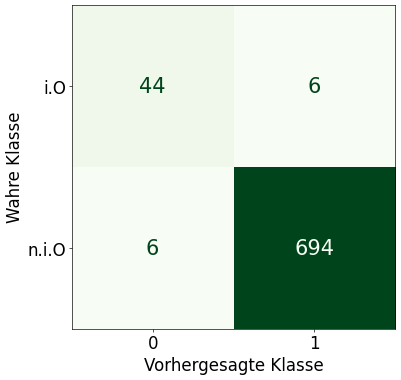

In [38]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [39]:
def collect_results(clf, y_true, y_pred, algorithm, params, best_param):
    
    res = {"algorithm":algorithm, "params":params, "best_param":best_param,
           "rec_0":None, "pre_0":None, "f1_0":None, "rec_weighted":None, "pre_weighted":None, "f1_weighted":None, "acc":None}
    
    y_true0 = ch.swap_zero_one(y_true, 0)
    y_pred0 = ch.swap_zero_one(y_pred, 0)
    
    res["rec_0"] = recall_score(y_true0, y_pred0)
    res["pre_0"] = precision_score(y_true0, y_pred0)
    res["f1_0"] = f1_score(y_true0, y_pred0)
    res["rec_weighted"]= recall_score(y_true, y_pred, average='weighted')
    res["f1_weighted"]= f1_score(y_true, y_pred, average='weighted')
    res["pre_weighted"]= precision_score(y_true, y_pred, average='weighted')
    res["acc"] = accuracy_score(y_true, y_pred)
    
    for val in res.keys():
        if res[val]==None:
            print("somethong is wrong")
    
    return res

In [40]:
res = collect_results(best_clf, y_test, y_pred, algorithm="knn", params=parameters, best_param=search.best_params_)
res

{'algorithm': 'knn',
 'params': {'classifier__n_neighbors': [1, 3, 5, 8, 12, 16, 24, 36],
  'classifier__weights': ['uniform', 'distance'],
  'classifier__algorithm': ['ball_tree', 'kd_tree', 'brute'],
  'classifier__p': [1, 2, 3, 4, 5]},
 'best_param': {'classifier__algorithm': 'ball_tree',
  'classifier__n_neighbors': 1,
  'classifier__p': 1,
  'classifier__weights': 'uniform'},
 'rec_0': 0.9914285714285714,
 'pre_0': 0.9914285714285714,
 'f1_0': 0.9914285714285714,
 'rec_weighted': 0.7266666666666667,
 'pre_weighted': 0.7964113964188807,
 'f1_weighted': 0.7570642188434914,
 'acc': 0.6133333333333333}

In [41]:
filename = "mlc_ml_br_hyperopt_results_v2.4.json"
key_algorithm = "knn"
hyperopt_result = res

In [42]:
if os.path.exists(f"results/{filename}") == False:
    with open(f"results/{filename}", "w") as f:
        json.dump({f"{key_algorithm}":hyperopt_result}, f)
        f.close()
else:
    with open(f"results/{filename}", "r") as f:
        data = json.load(f)
        data.update({f"{key_algorithm}":hyperopt_result})
        
    with open(f"results/{filename}", "w") as f:
        json.dump(data, f)
        f.close()